## Generate static graphs

These are the input parameters for the notebook. They will be automatically changed when the scripts to generate monthly statistics are run. You can modify them manually to generate multiple plots locally as well.

Pass in `None` to remove the filters and plot all data. This is not recommended for production settings, but might be useful for reports based on data snapshots.

In [1]:
year = 2020
month = 11
program = "prepilot"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set()
%matplotlib inline

In [3]:
import scaffolding 
from plots import *

Connecting to database URL db


In [4]:
# Loading mapping dictionaries from mapping_dictionaries notebook
%store -r dic_ei
%store -r dic_re
%store -r dic_pur

dic_pur = scaffolding.Missing_dict(dic_pur)
dic_re  = scaffolding.Missing_dict(dic_re)

In [7]:
tq = scaffolding.get_time_query(year, month)

In [8]:
participant_ct_df = scaffolding.load_all_participant_trips(program, tq)

[UUID('576e37c7-ab7e-4c03-add7-02486bc3f42e'),
 UUID('8b563348-52b3-4e3e-b046-a0aaf4fcea15'),
 UUID('5079bb93-c9cf-46d7-a643-dfc86bb05605'),
 UUID('feabfccd-dd6c-4e8e-8517-9d7177042483'),
 UUID('113aef67-400e-4e21-a29f-d04e50fc42ea'),
 UUID('c8b9fe22-86f8-449a-b64f-c18a8d20eefc'),
 UUID('e7b24d99-324d-4d6d-b247-9edc87d3c848'),
 UUID('1044195f-af9e-43d4-9407-60594e5e9938'),
 UUID('898b1a5e-cdd4-4a0c-90e4-942fa298e456'),
 UUID('1d292b85-c549-409a-a10d-746e957582a0'),
 UUID('cb3222a7-1e72-4a92-8b7b-2c4795402497'),
 UUID('efdbea3b-eef6-48fc-9558-7585f4ad6f24'),
 UUID('960835ac-9d8a-421d-8b8a-bf816f8a4b92')]

Loaded all confirmed trips of length 4163


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationDistFilter,1.604619e+09,2020-11-05T15:35:02.264145-08:00,"{'type': 'Point', 'coordinates': [-122.3064180...",5fa4934b2b1f90a7e0aa8bb7,1.604616e+09,2020-11-05T14:45:03.188883-08:00,"{'type': 'Point', 'coordinates': [-122.1078901...",2999.075262,154119.051720,...,11,5,15,35,2,3,America/Los_Angeles,60053321db3d82eed967bdcc,4f84c5c7-a5f7-44b0-ab58-ef32adebf542,1.604621e+09
1,DwellSegmentationTimeFilter,1.604944e+09,2020-11-09T10:45:08-07:00,"{'type': 'Point', 'coordinates': [-105.0748688...",5faa1f9764a23cef325747c5,1.604944e+09,2020-11-09T10:42:18.751547-07:00,"{'type': 'Point', 'coordinates': [-105.0774552...",169.248453,1802.937694,...,11,9,10,45,8,0,America/Denver,600533215e173ffb99e0760b,3278d214-039d-4c3d-8b17-c1a91a9774d7,1.604985e+09
2,DwellSegmentationTimeFilter,1.607708e+09,2020-12-11T10:33:15-07:00,"{'type': 'Point', 'coordinates': [-104.9428725...",5fd3c2efb731c8e084cd53c6,1.607707e+09,2020-12-11T10:18:00-07:00,"{'type': 'Point', 'coordinates': [-105.0810427...",915.000000,15231.658380,...,12,11,10,33,15,4,America/Boise,600533215e173ffb99e0760c,3278d214-039d-4c3d-8b17-c1a91a9774d7,1.607714e+09
3,DwellSegmentationTimeFilter,1.607710e+09,2020-12-11T11:03:37-07:00,"{'type': 'Point', 'coordinates': [-104.7125987...",5fd409395ec2f0789d9d7839,1.607708e+09,2020-12-11T10:40:07.497020-07:00,"{'type': 'Point', 'coordinates': [-104.9428725...",1409.502980,26961.257901,...,12,11,11,3,37,4,America/Boise,600533215e173ffb99e0760d,3278d214-039d-4c3d-8b17-c1a91a9774d7,1.607732e+09
4,DwellSegmentationTimeFilter,1.607713e+09,2020-12-11T12:02:19.557000-07:00,"{'type': 'Point', 'coordinates': [-104.6747123...",5fd409395ec2f0789d9d783b,1.607710e+09,2020-12-11T11:06:37-07:00,"{'type': 'Point', 'coordinates': [-104.7125987...",3342.557000,3689.324814,...,12,11,12,2,19,4,America/Boise,600533215e173ffb99e0760e,3278d214-039d-4c3d-8b17-c1a91a9774d7,1.607732e+09


After filtering, found 3492 participant trips 


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
106,DwellSegmentationTimeFilter,1.604364e+09,2020-11-02T17:45:22.115000-07:00,"{'type': 'Point', 'coordinates': [-104.9409405...",5fa139609ae96f3a5fcdef31,1.604364e+09,2020-11-02T17:39:08.049000-07:00,"{'type': 'Point', 'coordinates': [-104.9398732...",374.066000,384.730231,...,11,2,17,45,22,0,America/Denver,600533265e173ffb99e07625,1d292b85-c549-409a-a10d-746e957582a0,1.604402e+09
108,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:12:12-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",5fa4690763a5e0e8d90c7fa4,1.604601e+09,2020-11-05T11:30:56.952000-07:00,"{'type': 'Point', 'coordinates': [-104.9479963...",2475.048000,13765.915676,...,11,5,12,12,12,3,America/Denver,600533265e173ffb99e07626,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09
109,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:27:22-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",5fa4690763a5e0e8d90c7fa8,1.604604e+09,2020-11-05T12:22:21.130739-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",300.869261,1508.223413,...,11,5,12,27,22,3,America/Denver,600533265e173ffb99e07627,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09
111,DwellSegmentationTimeFilter,1.604606e+09,2020-11-05T12:47:29.017000-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",5fa4690763a5e0e8d90c7faa,1.604605e+09,2020-11-05T12:42:19.793043-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",309.223957,434.038504,...,11,5,12,47,29,3,America/Denver,600533265e173ffb99e07628,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09
113,DwellSegmentationTimeFilter,1.604610e+09,2020-11-05T13:54:28.880000-07:00,"{'type': 'Point', 'coordinates': [-105.0824703...",5fa4771a533f6ebf89c7c5e3,1.604610e+09,2020-11-05T13:52:57.667396-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",91.212605,333.230154,...,11,5,13,54,28,3,America/Denver,600533265e173ffb99e07629,1d292b85-c549-409a-a10d-746e957582a0,1.604614e+09


In [9]:
labeled_ct = scaffolding.filter_labeled_trips(participant_ct_df)

After filtering, found 2425 labeled trips


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
106,DwellSegmentationTimeFilter,1.604364e+09,2020-11-02T17:45:22.115000-07:00,"{'type': 'Point', 'coordinates': [-104.9409405...",5fa139609ae96f3a5fcdef31,1.604364e+09,2020-11-02T17:39:08.049000-07:00,"{'type': 'Point', 'coordinates': [-104.9398732...",374.066000,384.730231,...,11,2,17,45,22,0,America/Denver,600533265e173ffb99e07625,1d292b85-c549-409a-a10d-746e957582a0,1.604402e+09
108,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:12:12-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",5fa4690763a5e0e8d90c7fa4,1.604601e+09,2020-11-05T11:30:56.952000-07:00,"{'type': 'Point', 'coordinates': [-104.9479963...",2475.048000,13765.915676,...,11,5,12,12,12,3,America/Denver,600533265e173ffb99e07626,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09
109,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:27:22-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",5fa4690763a5e0e8d90c7fa8,1.604604e+09,2020-11-05T12:22:21.130739-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",300.869261,1508.223413,...,11,5,12,27,22,3,America/Denver,600533265e173ffb99e07627,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09
111,DwellSegmentationTimeFilter,1.604606e+09,2020-11-05T12:47:29.017000-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",5fa4690763a5e0e8d90c7faa,1.604605e+09,2020-11-05T12:42:19.793043-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",309.223957,434.038504,...,11,5,12,47,29,3,America/Denver,600533265e173ffb99e07628,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09
113,DwellSegmentationTimeFilter,1.604610e+09,2020-11-05T13:54:28.880000-07:00,"{'type': 'Point', 'coordinates': [-105.0824703...",5fa4771a533f6ebf89c7c5e3,1.604610e+09,2020-11-05T13:52:57.667396-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",91.212605,333.230154,...,11,5,13,54,28,3,America/Denver,600533265e173ffb99e07629,1d292b85-c549-409a-a10d-746e957582a0,1.604614e+09


In [10]:
expanded_ct = scaffolding.expand_userinputs(labeled_ct)

,mode_confirm,purpose_confirm,replaced_mode
106,walk,meal,same_mode
108,train,personal_med,same_mode
109,skateboard,transit_transfer,bus
111,not_a_trip,transit_transfer,same_mode
113,not_a_trip,transit_transfer,same_mode


After expanding, columns went from 33 -> 36


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,mode_confirm,purpose_confirm,replaced_mode
106,DwellSegmentationTimeFilter,1.604364e+09,2020-11-02T17:45:22.115000-07:00,"{'type': 'Point', 'coordinates': [-104.9409405...",5fa139609ae96f3a5fcdef31,1.604364e+09,2020-11-02T17:39:08.049000-07:00,"{'type': 'Point', 'coordinates': [-104.9398732...",374.066000,384.730231,...,45,22,0,America/Denver,600533265e173ffb99e07625,1d292b85-c549-409a-a10d-746e957582a0,1.604402e+09,walk,meal,same_mode
108,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:12:12-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",5fa4690763a5e0e8d90c7fa4,1.604601e+09,2020-11-05T11:30:56.952000-07:00,"{'type': 'Point', 'coordinates': [-104.9479963...",2475.048000,13765.915676,...,12,12,3,America/Denver,600533265e173ffb99e07626,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,train,personal_med,same_mode
109,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:27:22-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",5fa4690763a5e0e8d90c7fa8,1.604604e+09,2020-11-05T12:22:21.130739-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",300.869261,1508.223413,...,27,22,3,America/Denver,600533265e173ffb99e07627,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,skateboard,transit_transfer,bus
111,DwellSegmentationTimeFilter,1.604606e+09,2020-11-05T12:47:29.017000-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",5fa4690763a5e0e8d90c7faa,1.604605e+09,2020-11-05T12:42:19.793043-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",309.223957,434.038504,...,47,29,3,America/Denver,600533265e173ffb99e07628,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,not_a_trip,transit_transfer,same_mode
113,DwellSegmentationTimeFilter,1.604610e+09,2020-11-05T13:54:28.880000-07:00,"{'type': 'Point', 'coordinates': [-105.0824703...",5fa4771a533f6ebf89c7c5e3,1.604610e+09,2020-11-05T13:52:57.667396-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",91.212605,333.230154,...,54,28,3,America/Denver,600533265e173ffb99e07629,1d292b85-c549-409a-a10d-746e957582a0,1.604614e+09,not_a_trip,transit_transfer,same_mode


In [15]:
expanded_ct.columns

Index(['source', 'end_ts', 'end_fmt_time', 'end_loc', 'raw_trip', 'start_ts',
       'start_fmt_time', 'start_loc', 'duration', 'distance', 'start_place',
       'end_place', 'cleaned_trip', 'user_input', 'start_local_dt_year',
       'start_local_dt_month', 'start_local_dt_day', 'start_local_dt_hour',
       'start_local_dt_minute', 'start_local_dt_second',
       'start_local_dt_weekday', 'start_local_dt_timezone',
       'end_local_dt_year', 'end_local_dt_month', 'end_local_dt_day',
       'end_local_dt_hour', 'end_local_dt_minute', 'end_local_dt_second',
       'end_local_dt_weekday', 'end_local_dt_timezone', '_id', 'user_id',
       'metadata_write_ts', 'mode_confirm', 'purpose_confirm', 'replaced_mode',
       'Trip_purpose', 'Mode_confirm', 'Replaced_mode'],
      dtype='object')

In [16]:
expanded_ct.shape

(2374, 39)

In [17]:
expanded_ct = scaffolding.data_quality_check(expanded_ct)
expanded_ct.shape

(2374, 39)

In [18]:
## Mapping new labels with dictionaries
expanded_ct['Trip_purpose']= expanded_ct['purpose_confirm'].replace(dic_pur)
expanded_ct['Mode_confirm']= expanded_ct['mode_confirm'].map(dic_re)
expanded_ct['Replaced_mode']= expanded_ct['replaced_mode'].map(dic_re)

In [19]:
# Energy Impact Calculation
expanded_ct = scaffolding.energy_cal(expanded_ct,dic_ei)

In [20]:
file_suffix = scaffolding.get_file_suffix(year, month, program)
quality_text = scaffolding.get_quality_text(participant_ct_df, expanded_ct)


Based on 2374 confirmed trips from 12 users
of 3492 total trips from 13 users (67.98%)


# Distribution of Mode_confirm Attribute

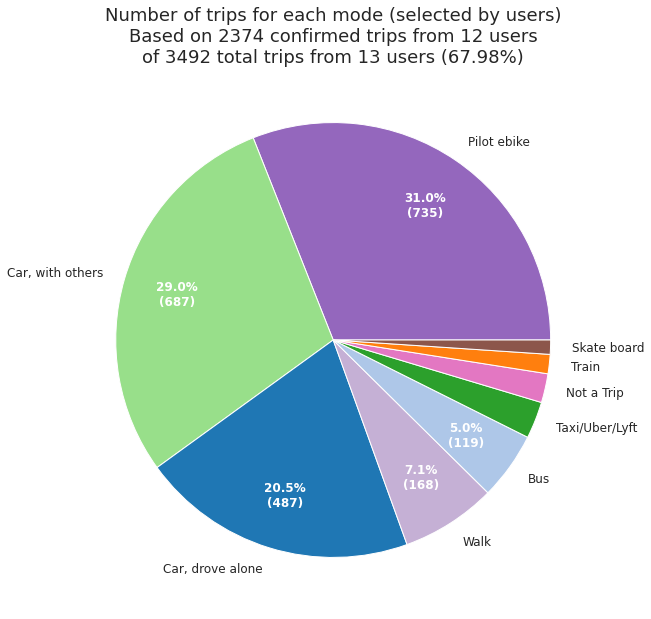

In [21]:
labels_mc = expanded_ct['Mode_confirm'].value_counts(dropna=True)[:9].keys().tolist()
values_mc = expanded_ct['Mode_confirm'].value_counts(dropna=True)[:9].tolist()
plot_title= "Number of trips for each mode (selected by users)\n%s" % quality_text
file_name= 'ntrips_mode_confirm%s.png' % file_suffix
pie_chart_mode(plot_title,labels_mc,values_mc,file_name)

# Distribution of Replace_Mode Attribute

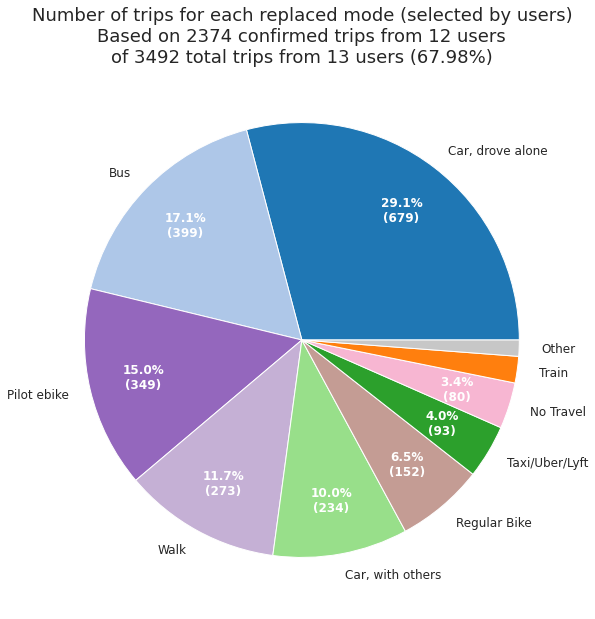

In [22]:
labels_rm = expanded_ct['Replaced_mode'].value_counts(dropna=True)[:10].keys().tolist()
values_rm = expanded_ct['Replaced_mode'].value_counts(dropna=True)[:10].tolist()
plot_title="Number of trips for each replaced mode (selected by users)\n%s" % quality_text
file_name= 'ntrips_replaced_mode%s.png' % file_suffix
pie_chart_mode(plot_title,labels_rm,values_rm,file_name)

### Note: The portion of pilot ebikes in the pie chart above is only when the mode_confirm is different that ebike. Example: mode_confirm was Walk, replaced_mode ebike. 
###           mode_confrim was Car, drove alone, replaced_mode ebike.

In [23]:
expanded_ct.loc[expanded_ct['Replaced_mode'] == 'Pilot ebike'].Mode_confirm.unique()

array(['Car, with others', 'Car, drove alone', 'Walk', 'Bikeshare',
       'Taxi/Uber/Lyft', 'Bus', 'Train', 'Pilot ebike'], dtype=object)

# Distribution of Trip Purpose Attribute

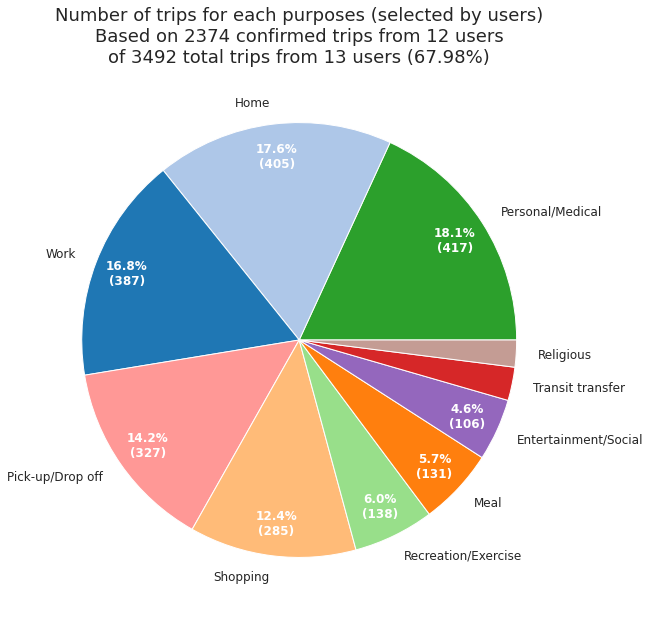

In [24]:
labels_tp = expanded_ct['Trip_purpose'].value_counts(dropna=True)[:10].keys().tolist()
values_tp = expanded_ct['Trip_purpose'].value_counts(dropna=True)[:10].tolist()
plot_title="Number of trips for each purposes (selected by users)\n%s" % quality_text
file_name= 'ntrips_purpose%s.png' % file_suffix
pie_chart_purpose(plot_title,labels_tp,values_tp,file_name)

# Transport of Choice for Trips Under 10 Miles

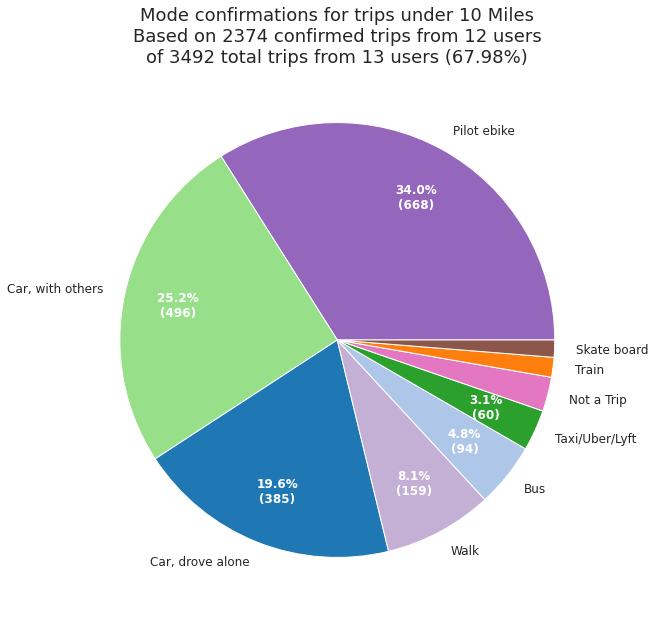

In [25]:
labels_d10 = expanded_ct.loc[(expanded_ct['distance_miles'] <= 10)].Mode_confirm.value_counts(dropna=True)[:10].keys().tolist()
values_d10 = expanded_ct.loc[(expanded_ct['distance_miles'] <= 10)].Mode_confirm.value_counts(dropna=True)[:10].tolist()
plot_title="Mode confirmations for trips under 10 Miles\n%s" % quality_text
file_name ='ntrips_under10miles_mode_confirm%s.png' % file_suffix
pie_chart_mode(plot_title,labels_d10,values_d10,file_name)

# Miles per transport mode selected (Mode_confirm)

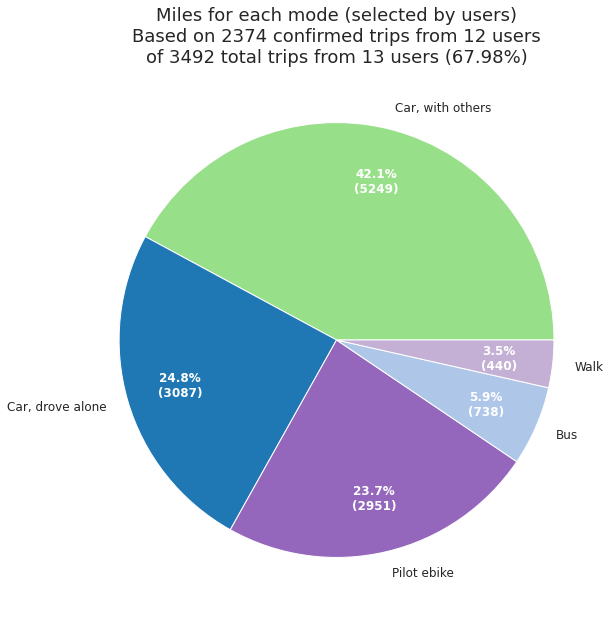

        Mode_confirm  Total (miles)  Count  Average (miles)
3   Car, with others    5249.012513    687         7.640484
2   Car, drove alone    3086.503689    487         6.337790
5        Pilot ebike    2950.929269    735         4.014870
1                Bus     737.754956    119         6.199621
11              Walk     439.788377    168         2.617788
9     Taxi/Uber/Lyft     271.265564     65         4.173316
10             Train     238.272699     34         7.008021
4         Not a Trip      46.579936     51         0.913332
7      Scooter share      19.404838      1        19.404838
8        Skate board      13.528083     25         0.541123
0          Bikeshare      11.333995      1        11.333995
6       Regular Bike      10.114039      1        10.114039


In [26]:
miles = expanded_ct.groupby('Mode_confirm').agg({'distance_miles': ['sum', 'count' , 'mean']})
miles.columns = ['Total (miles)', 'Count', 'Average (miles)']
miles = miles.reset_index()
miles =miles.sort_values(by=['Total (miles)'], ascending=False)

#data
miles_dict = dict(zip(miles['Mode_confirm'], miles['Total (miles)']))

labels_m = []
values_m = []

for x, y in miles_dict.items():
    labels_m.append(x)
    values_m.append(y)

labels_miles = labels_m[:5]
values_miles = values_m[:5]
plot_title="Miles for each mode (selected by users)\n%s" % quality_text
file_name ='miles_mode_confirm%s.png' % file_suffix
pie_chart_mode(plot_title,labels_miles,values_miles,file_name)
print(miles)